In [53]:
import pandas as pd
import math
import string
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet



# read data

reviews = pd.read_csv("Hotel_Reviews.csv")

# append the positive and negative text reviews
reviews["review"] = reviews["reviews.text"] + reviews["reviews.title"]

# create the label and make information easy to understanding
reviews["is_good_review"] = reviews["reviews.rating"].apply(lambda x: 1 if x > 3 else 0)

# If it bad is 0
#If it goof is 1

reviews = reviews[["review", "is_good_review"]]
reviews.head()


,review,is_good_review
0,"This hotel was nice and quiet. Did not know, t...",0
1,We stayed in the king suite with the separatio...,1
2,"Parking was horrible, somebody ran into my ren...",0
3,Not cheap but excellent location. Price is som...,1
4,If you get the room that they advertised on th...,0


In [54]:
print(reviews["review"] )

0       This hotel was nice and quiet. Did not know, t...
1       We stayed in the king suite with the separatio...
2       Parking was horrible, somebody ran into my ren...
3       Not cheap but excellent location. Price is som...
4       If you get the room that they advertised on th...
                              ...                        
9995    My friends and I took a trip to Hampton for th...
9996    from check in to departure, staff is friendly,...
9997    This Hampton is located on a quiet street acro...
9998    Awesome wings (my favorite was garlic parmesan...
9999    Clean facility just off freeway ..... staff fr...
Name: review, Length: 10000, dtype: object


In [55]:

# return the wordnet object value corresponding to the POS tag
def get_wordnet_pos(pos_tag):
    
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    
    else:
        return wordnet.NOUN
    

In [57]:
def clean_text(text):
    
    # lower text
    text = text.lower()
    # tokenize text and remove puncutation
    
    text = [word.strip(string.punctuation) for word in text.split(" ")]
    
    # remove words that contain numbers
    text = [word for word in text if not any(c.isdigit() for c in word)]
    
    # remove stop words
    stop = stopwords.words('english')
    text = [x for x in text if x not in stop]
    
    # remove empty tokens
    text = [t for t in text if len(t) > 0]
    
    # pos tag text
    pos_tags = pos_tag(text)
    
    # lemmatize text
    text = [WordNetLemmatizer().lemmatize(t[0], get_wordnet_pos(t[1])) for t in pos_tags]
    
    # remove words with only one letter
    text = [t for t in text if len(t) > 1]
    
    # join all
    text = " ".join(text)
    return(text)

# clean text data
#4768 
for i in range(len(reviews["review"])): reviews["review_clean"] = clean_text(reviews["review"][i]) 

In [58]:
#add sentiment anaylsis columns
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer()
reviews["sentiments"] = reviews["review"].apply(lambda x: sid.polarity_scores(x))
reviews = pd.concat([reviews.drop(['sentiments'], axis=1), reviews['sentiments'].apply(pd.Series)], axis=1)

In [59]:

# add number of characters column
reviews["nb_chars"] = reviews["review"].apply(lambda x: len(x))

# add number of words column
reviews["nb_words"] = reviews["review"].apply(lambda x: len(x.split(" ")))

In [60]:
#create doc2vec vector columns
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(reviews["review_clean"].apply(lambda x: x.split(" ")))]

# train a Doc2Vec model with our text data
model = Doc2Vec(documents, vector_size=5, window=2, min_count=1, workers=4)

# transform each document into a vector data
doc2vec = reviews["review_clean"].apply(lambda x: model.infer_vector(x.split(" "))).apply(pd.Series)
doc2vec.columns = ["doc2vec_vector_" + str(x) for x in doc2vec.columns]
reviews = pd.concat([reviews, doc2vec], axis=1)

In [61]:
# add tf-idfs columns
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(min_df = 10)
tfidf_result = tfidf.fit_transform(reviews["review_clean"]).toarray()
tfidf_df = pd.DataFrame(tfidf_result, columns = tfidf.get_feature_names())
tfidf_df.columns = ["word_" + str(x) for x in tfidf_df.columns]
tfidf_df.index = reviews.index
reviews = pd.concat([reviews, tfidf_df], axis=1)

In [62]:
reviews["is_good_review"].value_counts(normalize = True)

1    0.7689
0    0.2311
Name: is_good_review, dtype: float64

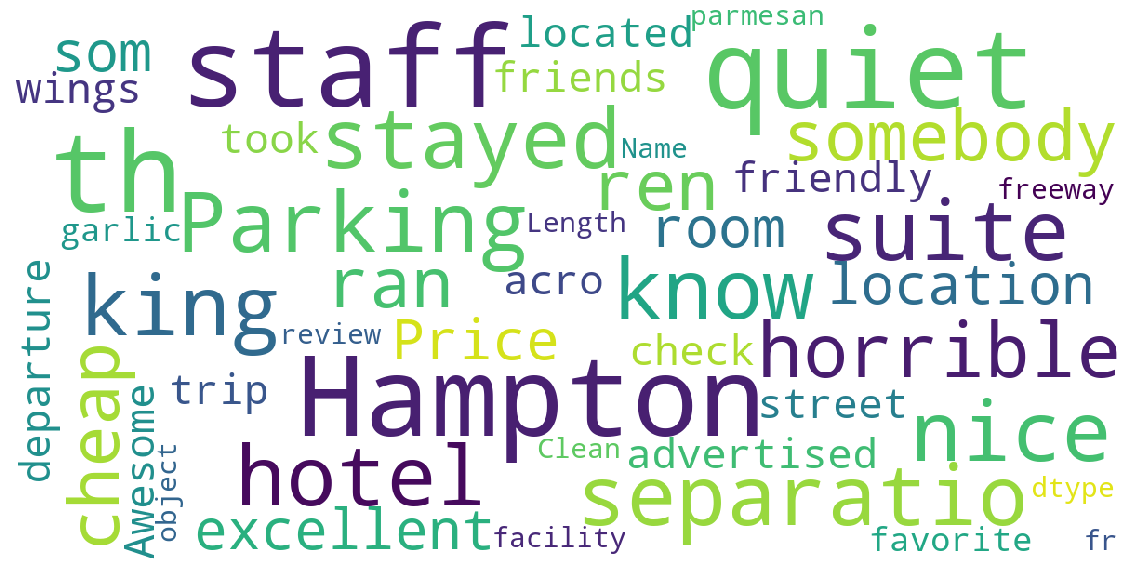

In [63]:
# wordcloud function

from wordcloud import WordCloud
import matplotlib.pyplot as plt

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color = 'white',
        max_words = 200,
        max_font_size = 40, 
        scale = 3,
        random_state = 42
    ).generate(str(data))

    fig = plt.figure(1, figsize = (20, 20))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize = 20)
        fig.subplots_adjust(top = 2.3)

    plt.imshow(wordcloud)
    plt.show()
    
# print wordcloud
show_wordcloud(reviews["review"])

In [66]:
# highest positive sentiment reviews (with more than 5 words)
reviews[reviews["nb_words"] >= 5].sort_values("pos", ascending = False)[["review", "pos"]].head(10)

,review,pos
5185,"Wow Very clean, awesome pool, awesome breakfas...",0.657
1975,The staff was very friendly and truly made my ...,0.590
8823,"Wonderful staff, friendly and helpful. Accommo...",0.583
9642,Great Hotel. Clean and comfortable. Excellent ...,0.572
7285,Beautiful hotel. The staff was friendly and he...,0.568
7254,This hotel is perfectly located on busy Duval ...,0.566
7308,Enjoyed my stay there! Always a pleasure stayi...,0.559
548,"Staff were great!! polite and professional, al...",0.549
5982,This is a great JWM. Staff was excellent - ver...,0.548
9529,Great location had a great time! recommend thi...,0.546


In [68]:
# lowest negative sentiment reviews (with more than 5 words)
reviews[reviews["nb_words"] >= 5].sort_values("neg", ascending = False)[["review", "neg"]].head(10)


,review,neg
3636,The staff here is horrible and the manager suc...,0.438
8718,"Employees rude, not helpful. Drugs run amuck h...",0.391
2334,"There is no fridge, no microwave, no hanger. T...",0.362
6977,"The pictures were dirty with brown stuff, the ...",0.341
6591,Very upset with my stay at this hotel. Room is...,0.333
3876,Rude clerk at check in. After a long wait! Roo...,0.328
9,"Hello, I have traveled a lot and abroad and by...",0.317
4481,"Ice machine broken, telephone broken, ice buck...",0.309
8980,MoreMoreWyndham doesn't care about needs of gu...,0.305
4132,"Infected of fleas and thumbtacks, bedbags infe...",0.302


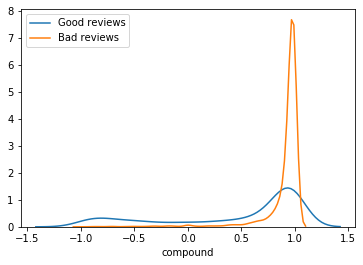

In [72]:
# plot sentiment distribution for positive and negative reviews

import seaborn as sns

for x in [0, 1]:
    subset = reviews[reviews['is_good_review'] == x]
    
    # Draw the density plot
    if x == 0:
        label = "Good reviews"
    else:
        label = "Bad reviews"
    sns.distplot(subset['compound'], hist = False, label = label)